### Import Libraries

In [1]:
# Import libraries
import numpy as np # NumPy
import matplotlib.pyplot as plt # Matplotlib
from scipy.fftpack import dct, idct # DCT, Inverse
from skimage.metrics import structural_similarity as ssim # SSIM
from scipy.signal import wiener, medfilt # Wiener filter, Medium filter
import scipy # Scipy

### Part I - Digital Communications and Coding

**Task 1: Testing BPSK**

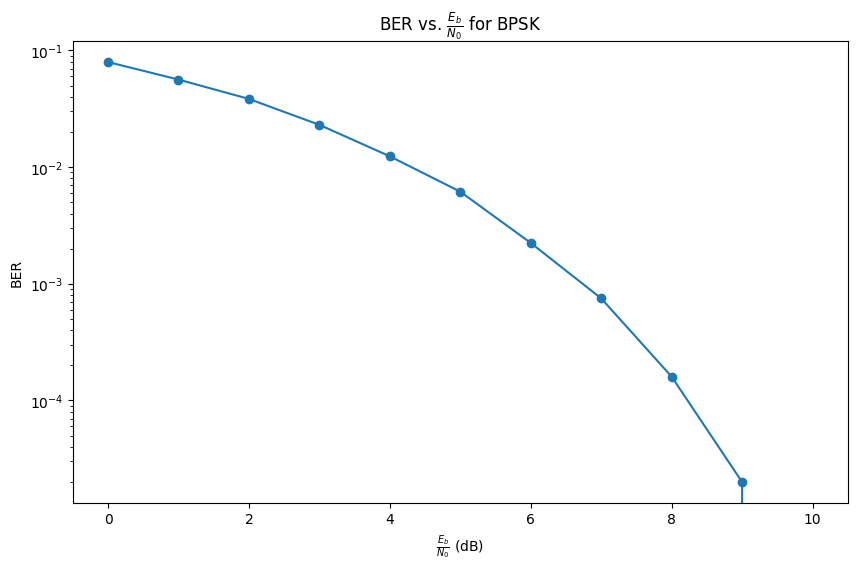

In [2]:
# Define the range of Eb/N0 values to be tested
Eb_N0_range = np.arange(0, 11, 1)
# Initialize an empty list to store the Bit Error Rates (BERs) for each Eb/N0
BERs = []
# Number of bits to be transmitted in each iteration
N = 100000
# Iterate over each Eb/N0 value
for Eb_N0 in Eb_N0_range:
 # Convert Eb/N0 from dB to linear scale
 Eb_N0_linear = 10 ** (Eb_N0 / 10)

 # Calculate the noise variance using Eb/N0
 sigma2 = 1 / (2 * Eb_N0_linear)

 # Generate N random bits (0 or 1)
 bits = np.random.randint(0, 2, N)

 # Map bits to BPSK symbols (-1 or 1)
 symbols = 2 * bits - 1

 # Generate Gaussian noise with zero mean and variance sigma^2
 noise = np.sqrt(sigma2) * np.random.randn(N)

 # Add noise to the transmitted symbols
 received = symbols + noise

 # Decode received symbols based on the decision rule (0 if received signal
 decoded = (received > 0).astype(int)

 # Calculate the Bit Error Rate (BER) by comparing transmitted and decoded
 BER = np.sum(bits != decoded) / N

 # Append BER to the list
 BERs.append(BER)
# Plot BER vs Eb/N0
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_N0_range, BERs, 'o-')
plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
plt.ylabel('BER')
plt.title(r'BER vs. $\frac{E_b}{N_0}$ for BPSK')
plt.show()


**Task 2: Testing 4-QAM**

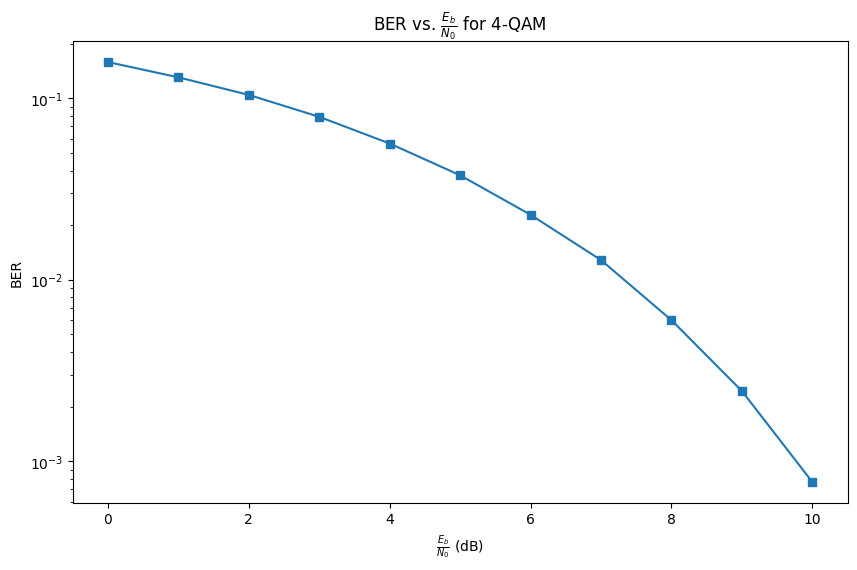

In [3]:
# Number of bits to be transmitted
N = 1000000
# Define the range of Eb/N0 values to be tested
Eb_N0_range = np.arange(0, 11, 1)
# Initialize an empty list to store the Bit Error Rates (BERs) for 4-QAM modul
BERs_4QAM = []
# Iterate over each Eb/N0 value
for Eb_N0 in Eb_N0_range:
 # Convert Eb/N0 from dB to linear scale
 Eb_N0_linear = 10**(Eb_N0 / 10)

 # Calculate the noise variance using Eb/N0 (scaling for 4-QAM)
 sigma2 = 1 / (2 * Eb_N0_linear) * 2

 # Generate N/2 random bits for 4-QAM modulation
 bits = np.random.randint(0, 4, N//2)

 # Map bits to 4-QAM symbols
 symbols = (
 np.sqrt(1/2) * (2*(bits % 2) - 1) +
 1j * np.sqrt(1/2) * (2*(bits // 2) - 1)
 )

 # Generate complex Gaussian noise with zero mean and variance sigma^2/2
 noise = np.sqrt(sigma2/2) * (
 np.random.randn(N//2) + 1j * np.random.randn(N//2)
 )

 # Add noise to the transmitted symbols
 received = symbols + noise

 # Decode received symbols
 decoded = np.zeros(N, dtype=int)
 decoded[0::2] = (received.real > 0).astype(int)
 decoded[1::2] = (received.imag > 0).astype(int)

 # Generate the original bits from the symbols for comparison
 orig_bits = np.zeros(N, dtype=int)
 orig_bits[0::2] = bits % 2
 orig_bits[1::2] = bits // 2

 # Calculate the Bit Error Rate (BER) for 4-QAM
 BER = np.sum(orig_bits != decoded) / N
 BERs_4QAM.append(BER)
# Plot BER vs Eb/N0 for 4-QAM
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_N0_range, BERs_4QAM, 's-', label='4-QAM')
plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
plt.ylabel('BER')
plt.title(r'BER vs. $\frac{E_b}{N_0}$ for 4-QAM')
plt.show()


**Task 3: More Complex QAM**

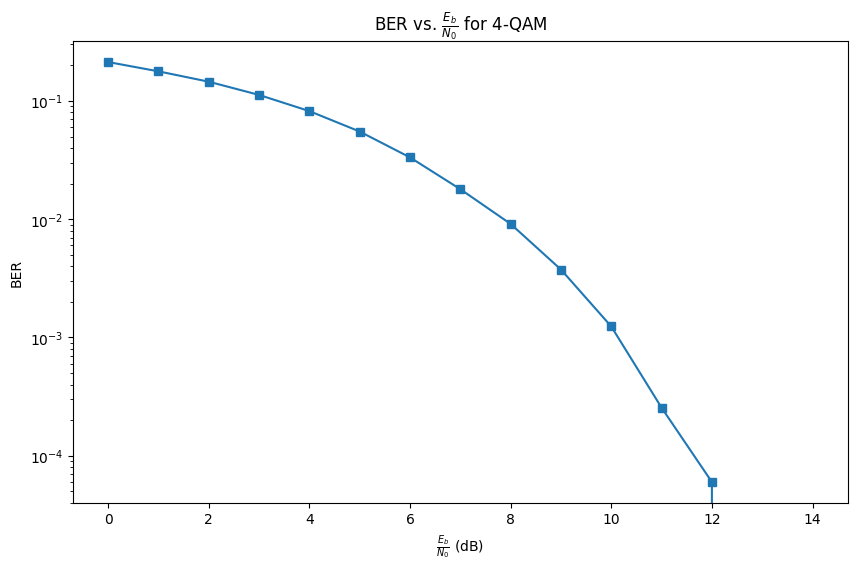

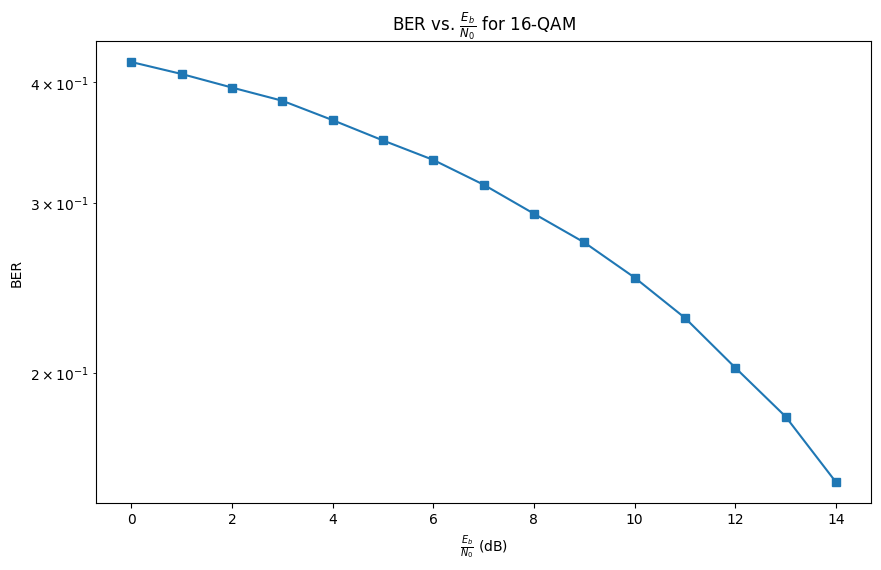

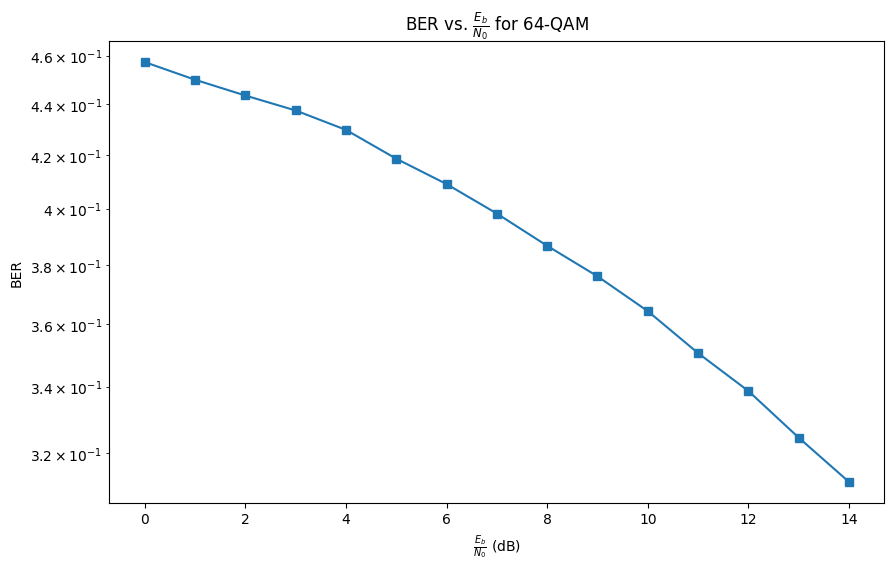

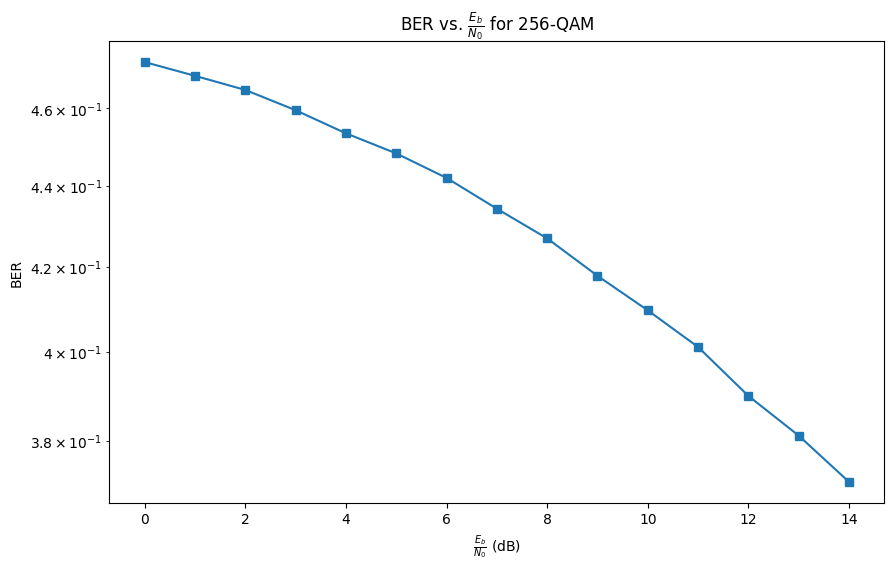

In [4]:
# Function to generate the QAM constellation points
def generate_constellation(d):
    M = 2**d
    # Generate QAM constellation points using Gray coding
    constellation = np.array([np.exp(1j * (2*np.pi*m / M + np.pi / M)) for m in range(M)])
    # Normalize the constellation points to have unit average power
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    return constellation

# Function to map bits to QAM symbols
def bits2sym(bits, constellation, d):
    M = len(constellation)
    # Convert bits to symbols by indexing the constellation array
    symbols = np.array([constellation[int(''.join(str(b) for b in bits[i:i+d]), 2)] for i in range(0, len(bits), d)])
    return symbols
    
# Function to demodulate received symbols to bits
def demod_sym(received, constellation, d):
    demod_bits = []
    for symbol in received:
        # Find the closest constellation point to the received symbol
        closest = constellation[np.argmin(np.abs(symbol - constellation))]
        closest_idx = np.where(constellation == closest)[0][0]
        # Convert the index of the closest point to bits using Gray coding
        demod_bits.extend([int(x) for x in np.binary_repr(closest_idx, width=d)])
    return np.array(demod_bits)

# Function to simulate QAM modulation and calculate BER
def sim_QAM(d, Eb_N0_range, N):
    BERs = []
    constellation = generate_constellation(d)
    for Eb_N0 in Eb_N0_range:
        # Convert Eb/N0 from dB to linear scale
        Eb_N0_linear = 10**(Eb_N0 / 10)
        # Calculate the noise variance using Eb/N0 (scaling for QAM)
        sigma2 = 1 / (2 * Eb_N0_linear) * d
        # Generate random bits for transmission
        bits = np.random.randint(0, 2, N*d)
        # Map bits to QAM symbols
        symbols = bits2sym(bits, constellation, d)
        # Generate complex Gaussian noise with zero mean and variance sigma^2/
        noise = np.sqrt(sigma2/2) * (np.random.randn(len(symbols)) + 1j * np.random.randn(len(symbols)))
        # Add noise to the transmitted symbols
        received = symbols + noise
        # Demodulate received symbols to obtain decoded bits
        demod_bits = demod_sym(received, constellation, d)
        # Calculate the Bit Error Rate (BER)
        BER = np.sum(bits[:len(demod_bits)] != demod_bits) / len(demod_bits)
        BERs.append(BER)

    # Plot BER vs Eb/N0 for the specific QAM modulation
    plt.figure(figsize=(10,6))
    plt.semilogy(Eb_N0_range, BERs, 's-', label=f'{2**d}-QAM')
    plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
    plt.ylabel('BER')
    plt.title(r'BER vs. $\frac{E_b}{N_0}$ for ' + f'{2**d}-QAM')
    plt.show()
    return BERs

# Define the range of Eb/N0 values to be tested
Eb_N0_range = np.arange(0, 15, 1)
# Number of bits to be transmitted
N = 100000
# Simulate QAM modulation for different modulation orders
BER_d2 = sim_QAM(2, Eb_N0_range, N)
BER_d4 = sim_QAM(4, Eb_N0_range, N)
BER_d6 = sim_QAM(6, Eb_N0_range, N)
BER_d8 = sim_QAM(8, Eb_N0_range, N)


**Task 4: The Impact of Fading**

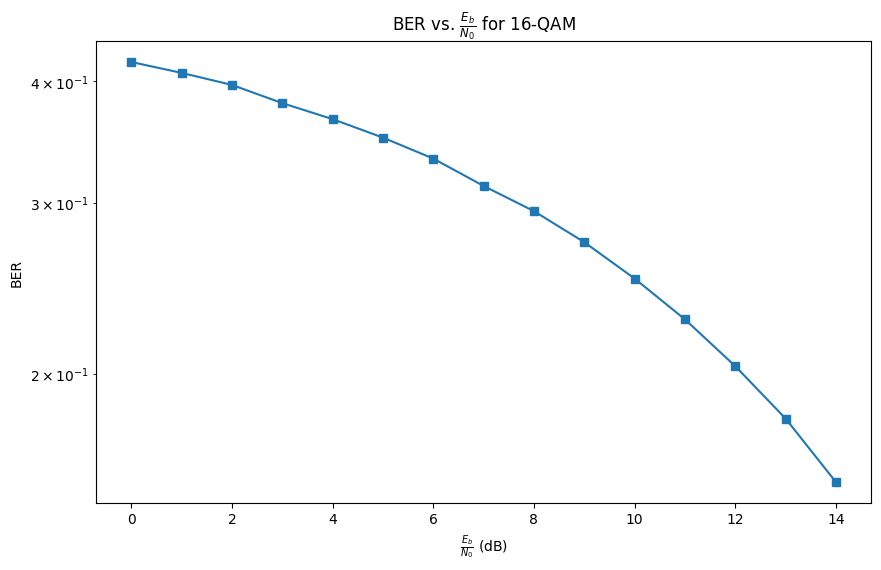

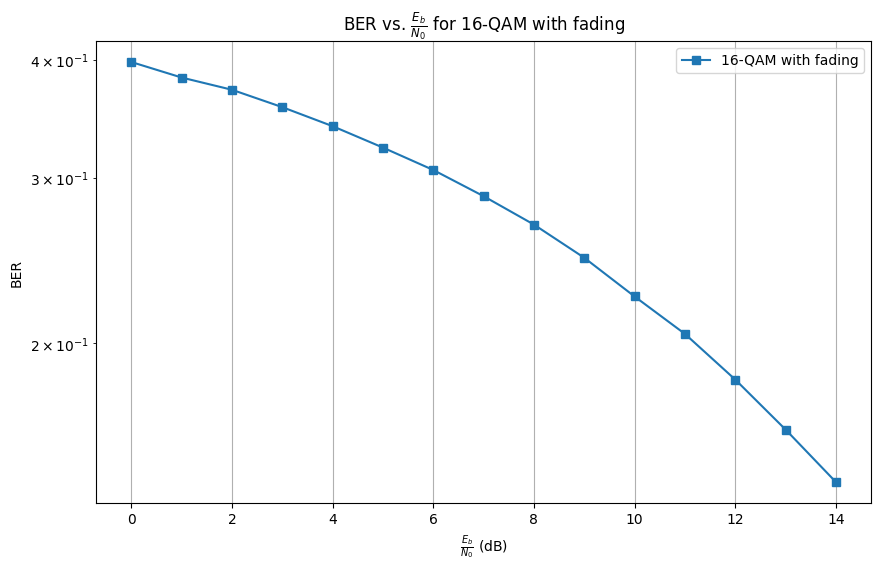

In [5]:
def generate_constellation(d):
    M = 2**d
    constellation = np.array([np.exp(1j * (2*np.pi*m / M + np.pi / M)) for m in range(M)])
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    return constellation

def bits2sym(bits, constellation, d):
    symbols = np.array([constellation[int(''.join(str(b) for b in bits[i:i+d]), 2)] for i in range(0, len(bits), d)])
    return symbols

def demod_sym(received, constellation, d):
    demod_bits = []
    for symbol in received:
        closest = constellation[np.argmin(np.abs(symbol - constellation))]
        closest_idx = np.where(constellation == closest)[0][0]
        demod_bits.extend([int(x) for x in np.binary_repr(closest_idx, width=d)])
    return np.array(demod_bits)

def sim_QAM_fading(d, Eb_N0_range, N):
    # Initialize an empty list to store the Bit Error Rates (BERs)
    BERs = []

    # Generate the QAM constellation points
    constellation = generate_constellation(d)

    # Iterate over each Eb/N0 value
    for Eb_N0 in Eb_N0_range:
        # Convert Eb/N0 from dB to linear scale
        Eb_N0_linear = 10**(Eb_N0 / 10)

        # Calculate the noise variance using Eb/N0 (scaling for QAM)
        sigma2 = 1 / (2 * Eb_N0_linear) * d

        # Generate random bits for transmission
        bits = np.random.randint(0, 2, N * d)

        # Map bits to QAM symbols
        symbols = bits2sym(bits, constellation, d)

        # Generate random fading channel coefficients
        H = np.random.normal(0, 1, (len(symbols),)) + 1j * np.random.normal(0, 1, (len(symbols),))

        # Introduce fading to the transmitted symbols
        faded_symbols = symbols * H

        # Generate complex Gaussian noise with zero mean and variance sigma^2
        noise = np.sqrt(sigma2/2) * (np.random.randn(len(faded_symbols)) + 1j * np.random.randn(len(faded_symbols)))

        # Add noise to the faded symbols
        received = faded_symbols + noise

        # Equalize the received symbols by dividing by the fading coefficients
        received_eq = received / H

        # Demodulate equalized received symbols to obtain decoded bits
        demod_bits = demod_sym(received_eq, constellation, d)

        # Calculate the Bit Error Rate (BER)
        BER = np.sum(bits[:len(demod_bits)] != demod_bits) / len(demod_bits)

        # Append BER to the list
        BERs.append(BER)

    # Plot BER vs Eb/N0 for QAM with fading
    plt.figure(figsize=(10, 6))
    plt.semilogy(Eb_N0_range, BERs, 's-', label=f'{2**d}-QAM with fading')
    plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
    plt.ylabel('BER')
    plt.title(r'BER vs. $\frac{E_b}{N_0}$ for ' + f'{2**d}-QAM with fading')
    plt.legend()
    plt.grid(True)
    plt.show()

    return BERs

# Define the range of Eb/N0 values to be tested
Eb_N0_range = np.arange(0, 15, 1)
# Number of bits to be transmitted
N = 100000
# Simulate QAM modulation without fading for d=4
BER_d4 = sim_QAM(4, Eb_N0_range, N)
# Simulate QAM modulation with fading for d=4
BER_d4_fading = sim_QAM_fading(4, Eb_N0_range, N)


### Part II - The Impact of Coding in Reliable Communications

**Task 5: Repetition Code**

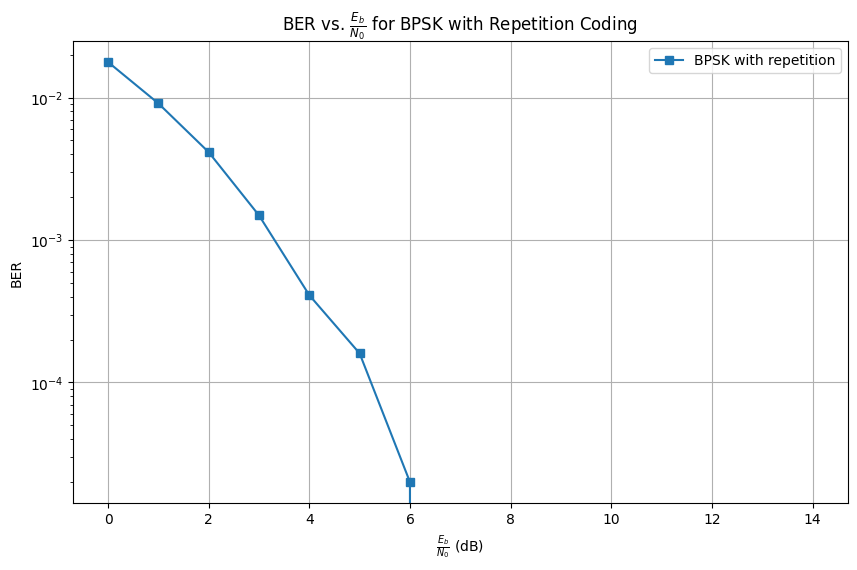

In [6]:
def sim_BPSK_repetition(Eb_N0_range, N, repeat):
    # Initialize an empty list to store the Bit Error Rates (BERs)
    BERs = []

    # Iterate over each Eb/N0 value
    for Eb_N0 in Eb_N0_range:
        # Convert Eb/N0 from dB to linear scale
        Eb_N0_linear = 10**(Eb_N0 / 10)

        # Calculate the noise variance using Eb/N0
        sigma2 = 1 / (2 * Eb_N0_linear)

        # Generate random bits for transmission
        bits = np.random.randint(0, 2, N)

        # Repeat each bit 'repeat' times
        repeated_bits = np.repeat(bits, repeat)

        # Map bits to BPSK symbols (-1 or 1)
        symbols = 2 * repeated_bits - 1

        # Generate Gaussian noise with zero mean and variance sigma^2
        noise = np.sqrt(sigma2) * np.random.randn(len(symbols))

        # Add noise to the transmitted symbols
        received = symbols + noise

        # Decode received symbols by majority voting
        received_bits = (received > 0).astype(int)
        voted_bits = np.zeros_like(bits)
        for i in range(N):
            voted_bits[i] = np.argmax(np.bincount(received_bits[i*repeat:(i+1)*repeat]))

        # Calculate the Bit Error Rate (BER)
        BER = np.sum(bits != voted_bits) / N
        BERs.append(BER)

    return BERs

# Parameters
repeat = 3
N = 100000
Eb_N0_range = np.arange(0, 15, 1)

# Simulate BPSK modulation with repetition coding
BER_repetition = sim_BPSK_repetition(Eb_N0_range, N, repeat)

# Plot BER vs Eb/N0 for BPSK with repetition coding
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_N0_range, BER_repetition, 's-', label='BPSK with repetition')
plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
plt.ylabel('BER')
plt.title(r'BER vs. $\frac{E_b}{N_0}$ for BPSK with Repetition Coding')
plt.legend()
plt.grid(True)
plt.show()


**Task 6: Other Codes**

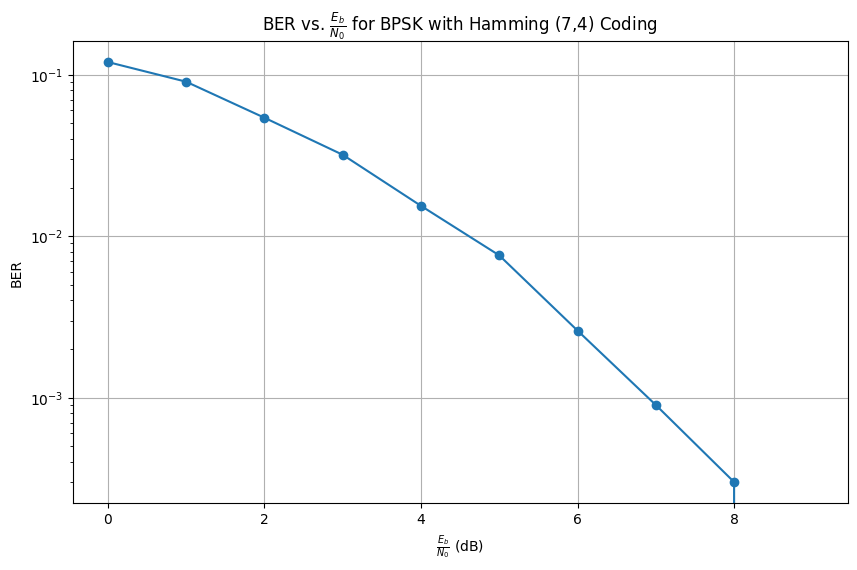

In [7]:
def hamming_encode(bits):
    # Generator matrix G for Hamming(7,4) code
    G = np.array([
        [1, 1, 0, 1],
        [1, 0, 1, 1],
        [1, 0, 0, 0],
        [0, 1, 1, 1],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]).T
    # Encode the bits using the generator matrix
    encoded_bits = np.dot(bits.reshape(-1, 4), G) % 2
    return encoded_bits.flatten()

def hamming_decode(bits):
    # Parity check matrix H for Hamming(7,4) code
    H = np.array([
        [1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ])
    # Syndrome decoding matrix R
    R = np.array([
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]
    ])
    # Reshape the received bits into a matrix
    bits = bits.reshape(-1, 7)
    # Calculate syndrome
    syndrome = np.dot(bits, H.T) % 2
    # Define error locations
    error_locs = np.packbits(np.array([1, 2, 4]), axis=-1)
    # Copy received bits for correction
    corrected_bits = bits.copy()
    # Decode based on syndrome
    for i in range(syndrome.shape[0]):
        if np.any(syndrome[i]):
            error_loc = np.where(np.all(syndrome[i] == H.T, axis=1))[0]
            if error_loc.size > 0:
                corrected_bits[i, error_loc[0]] ^= 1
    # Perform final decoding using R matrix
    decoded_bits = np.dot(corrected_bits, R.T) % 2
    return decoded_bits.flatten()

def sim_BPSK_hamming(Eb_N0, N_bits):
    # Define Hamming(7,4) parameters
    k = 4
    n = 7
    # Calculate the number of symbols needed
    N_symbols = int(np.ceil(N_bits / k)) * n
    # Generate random data bits
    data_bits = np.random.randint(0, 2, N_bits)
    # Encode data bits using Hamming encoding
    encoded_bits = hamming_encode(data_bits)
    # Modulate encoded bits using BPSK modulation
    modulated_signal = 2 * encoded_bits - 1

    # Calculate noise parameters
    Eb_N0_linear = 10 ** (Eb_N0 / 10)
    noise_std = np.sqrt(1 / (2 * Eb_N0_linear * k / n))

    # Generate Gaussian noise
    noise = noise_std * np.random.randn(N_symbols)

    # Add noise to the modulated signal
    received_signal = modulated_signal + noise
    received_bits = received_signal > 0

    # Decode received bits using Hamming decoding
    decoded_bits = hamming_decode(received_bits.astype(int))

    # Calculate Bit Error Rate (BER)
    bit_errors = np.sum(data_bits[:len(decoded_bits)] != decoded_bits)
    BER = bit_errors / len(decoded_bits)

    return BER

# Parameters
Eb_N0_range = np.arange(0, 10, 1)
N_bits = 10000
# List to store BERs for each Eb/N0
BERs = []
# Simulate BPSK with Hamming coding for each Eb/N0 value
for Eb_N0 in Eb_N0_range:
    BER = sim_BPSK_hamming(Eb_N0, N_bits)
    BERs.append(BER)

# Plot BER vs Eb/N0 for BPSK with Hamming(7,4) coding
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_N0_range, BERs, 'o-')
plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
plt.ylabel('BER')
plt.title(r'BER vs. $\frac{E_b}{N_0}$ for BPSK with Hamming (7,4) Coding')
plt.grid(True)
plt.show()


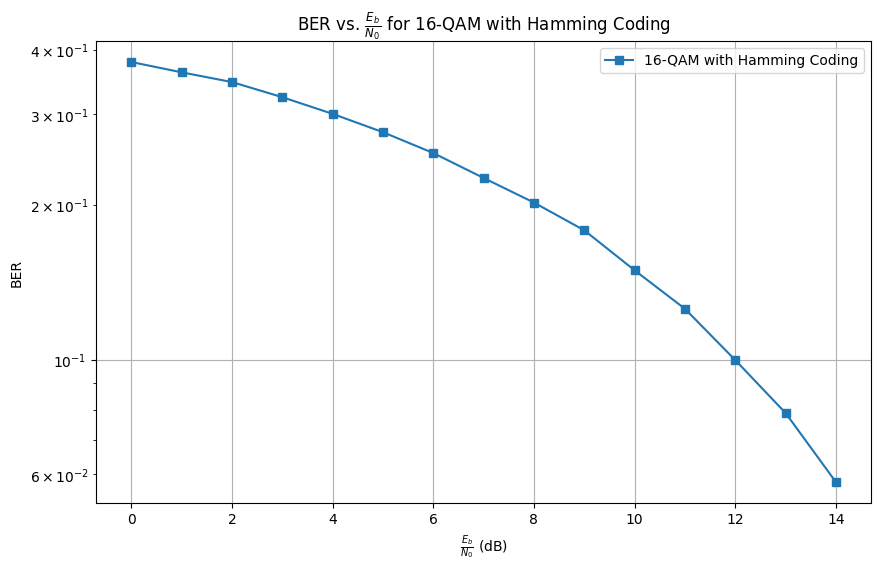

In [8]:
def sim_QAM_hamming(d, Eb_N0_range, N):
    # Initialize an empty list to store the Bit Error Rates (BERs)
    BERs = []

    # Generate the QAM constellation points
    constellation = generate_constellation(d)

    # Iterate over each Eb/N0 value
    for Eb_N0 in Eb_N0_range:
        # Convert Eb/N0 from dB to linear scale
        Eb_N0_linear = 10**(Eb_N0 / 10)

        # Calculate the noise variance using Eb/N0 (scaling for QAM and Hamming)
        sigma2 = 1 / (2 * Eb_N0_linear * 4 / 7)

        # Generate random bits for transmission
        bits = np.random.randint(0, 2, N)

        # Encode bits using Hamming (7,4) encoding
        encoded_bits = hamming_encode(bits.reshape(-1, 4)).astype(int)

        # Map encoded bits to QAM symbols
        symbols = bits2sym(encoded_bits, constellation, d)

        # Generate complex Gaussian noise with zero mean and variance sigma^2
        noise = np.sqrt(sigma2 / 2) * (np.random.randn(len(symbols)) + 1j * np.random.randn(len(symbols)))

        # Add noise to the transmitted symbols
        received = symbols + noise

        # Demodulate received symbols
        demod_bits = demod_sym(received, constellation, d)

        # Decode demodulated bits using Hamming (7,4) decoding
        decoded_bits = hamming_decode(demod_bits)

        # Calculate the Bit Error Rate (BER)
        BER = np.sum(bits[:len(decoded_bits)] != decoded_bits) / len(decoded_bits)
        BERs.append(BER)

    # Plot BER vs Eb/N0 for QAM with Hamming coding
    plt.figure(figsize=(10, 6))
    plt.semilogy(Eb_N0_range, BERs, 's-', label=f'{2**d}-QAM with Hamming Coding')
    plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
    plt.ylabel('BER')
    plt.title(r'BER vs. $\frac{E_b}{N_0}$ for ' + f'{2**d}-QAM with Hamming Coding')
    plt.legend()
    plt.grid(True)
    plt.show()

    return BERs

# Define the range of Eb/N0 values to be tested
Eb_N0_range = np.arange(0, 15, 1)
# Number of bits to be transmitted
N = 100000
# Simulate QAM with Hamming coding for d=4
BER_d4 = sim_QAM_hamming(4, Eb_N0_range, N)


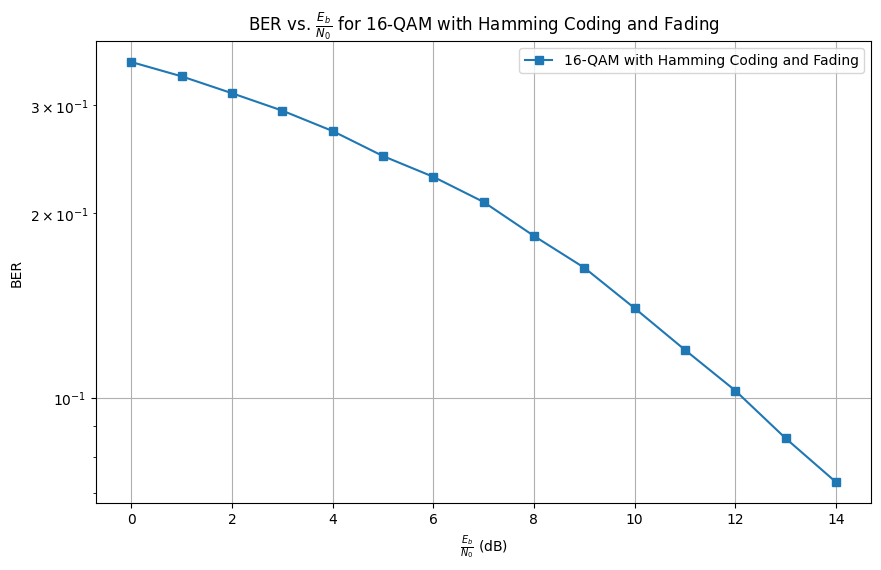

In [9]:
def sim_QAM_fading_hamming(d, Eb_N0_range, N):
    # Initialize an empty list to store the Bit Error Rates (BERs)
    BERs = []

    # Generate the QAM constellation points
    constellation = generate_constellation(d)

    # Iterate over each Eb/N0 value
    for Eb_N0 in Eb_N0_range:
        # Convert Eb/N0 from dB to linear scale
        Eb_N0_linear = 10**(Eb_N0 / 10)

        # Calculate the noise variance using Eb/N0 (scaling for QAM and Hamming)
        sigma2 = 1 / (2 * Eb_N0_linear * 4 / 7)

        # Generate random bits for transmission
        bits = np.random.randint(0, 2, N)

        # Encode bits using Hamming (7,4) encoding
        encoded_bits = hamming_encode(bits.reshape(-1, 4)).astype(int)

        # Map encoded bits to QAM symbols
        symbols = bits2sym(encoded_bits, constellation, d)

        # Generate random fading channel coefficients
        H = np.random.normal(0, 1, (len(symbols),)) + 1j * np.random.normal(0, 1, (len(symbols),))

        # Introduce fading to the transmitted symbols
        faded_symbols = symbols * H

        # Generate complex Gaussian noise with zero mean and variance sigma^2
        noise = np.sqrt(sigma2 / 2) * (np.random.randn(len(faded_symbols)) + 1j * np.random.randn(len(faded_symbols)))

        # Add noise to the faded symbols
        received = faded_symbols + noise

        # Equalize the received symbols by dividing by the fading coefficients
        received_eq = received / H

        # Demodulate equalized received symbols
        demod_bits = demod_sym(received_eq, constellation, d)

        # Decode demodulated bits using Hamming (7,4) decoding
        decoded_bits = hamming_decode(demod_bits)

        # Calculate the Bit Error Rate (BER)
        BER = np.sum(bits[:len(decoded_bits)] != decoded_bits) / len(decoded_bits)
        BERs.append(BER)

    # Plot BER vs Eb/N0 for QAM with Hamming coding and fading
    plt.figure(figsize=(10, 6))
    plt.semilogy(Eb_N0_range, BERs, 's-', label=f'{2**d}-QAM with Hamming Coding and Fading')
    plt.xlabel(r'$\frac{E_b}{N_0}$ (dB)')
    plt.ylabel('BER')
    plt.title(r'BER vs. $\frac{E_b}{N_0}$ for ' + f'{2**d}-QAM with Hamming Coding and Fading')
    plt.legend()
    plt.grid(True)
    plt.show()

    return BERs

# Define the range of Eb/N0 values to be tested
Eb_N0_range = np.arange(0, 15, 1)
# Number of bits to be transmitted
N = 100000
# Simulate QAM with Hamming coding and fading for d=4
BER_d4_fading = sim_QAM_fading_hamming(4, Eb_N0_range, N)


**Task 7: Taking it to the Limit**

Noise power: 0.10, Shannon Limit: 1.73, Actual Rate: 0.57, Eb/N0 (dB): 10.00
Noise power: 0.20, Shannon Limit: 1.29, Actual Rate: 0.57, Eb/N0 (dB): 6.99
Noise power: 0.30, Shannon Limit: 1.06, Actual Rate: 0.57, Eb/N0 (dB): 5.23
Noise power: 0.40, Shannon Limit: 0.90, Actual Rate: 0.57, Eb/N0 (dB): 3.98
Noise power: 0.50, Shannon Limit: 0.79, Actual Rate: 0.57, Eb/N0 (dB): 3.01
Noise power: 0.60, Shannon Limit: 0.71, Actual Rate: 0.57, Eb/N0 (dB): 2.22
Noise power: 0.70, Shannon Limit: 0.64, Actual Rate: 0.57, Eb/N0 (dB): 1.55
Noise power: 0.80, Shannon Limit: 0.58, Actual Rate: 0.57, Eb/N0 (dB): 0.97
Noise power: 0.90, Shannon Limit: 0.54, Actual Rate: 0.57, Eb/N0 (dB): 0.46
Noise power: 1.00, Shannon Limit: 0.50, Actual Rate: 0.57, Eb/N0 (dB): 0.00


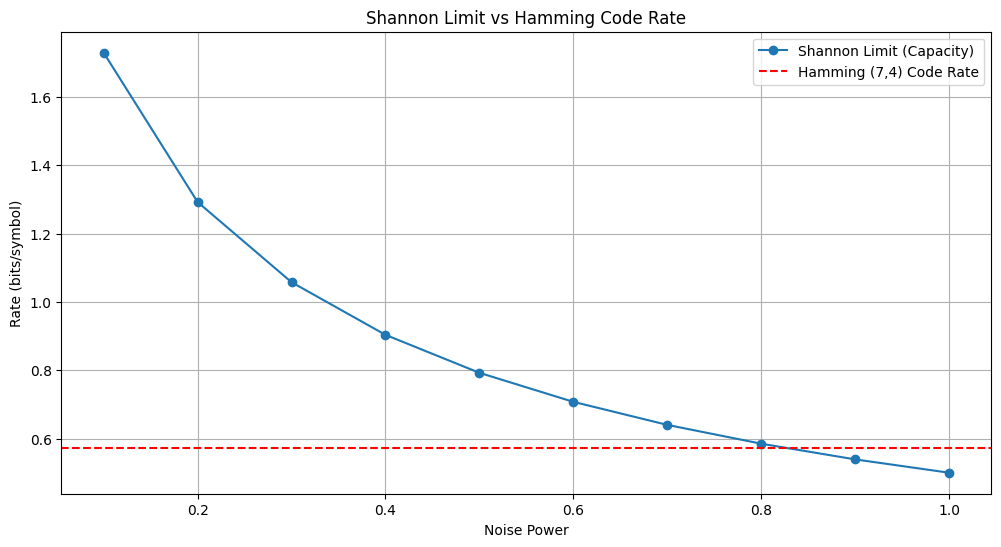

In [10]:
def shannon_limit(P, sigma2):
    # Calculate Shannon capacity limit
    return 0.5 * np.log2(1 + P / sigma2)

# Transmit power
P = 1

# Generate a range of noise variance values
sigma2_values = np.linspace(0.1, 1, 10)

# Calculate Shannon limits for each noise variance value
limits = [shannon_limit(P, sigma2) for sigma2 in sigma2_values]

# Hamming code rate (7,4)
hamming_rate = 4 / 7

# Iterate over each noise variance value
for sigma2, limit in zip(sigma2_values, limits):
    # Convert noise variance to Eb/N0 in dB
    Eb_N0_db = 10 * np.log10(P / sigma2)
    # Actual rate is fixed for Hamming coding
    actual_rate = hamming_rate
    # Print information about noise power, Shannon limit, actual rate, and closing statement
    print(f"Noise power: {sigma2:.2f}, Shannon Limit: {limit:.2f}, Actual Rate: {actual_rate:.2f}, Eb/N0 (dB): {Eb_N0_db:.2f}")

# Generate a range of noise power values
noise_powers = np.linspace(0.1, 1, 10)

# Calculate Shannon limits for each noise power value
shannon_limits = [shannon_limit(P, sigma2) for sigma2 in noise_powers]

# Plot Shannon limits and Hamming code rate
plt.figure(figsize=(12, 6))
plt.plot(noise_powers, shannon_limits, 'o-', label='Shannon Limit (Capacity)')
plt.axhline(y=hamming_rate, color='r', linestyle='--', label='Hamming (7,4) Code Rate')
plt.title('Shannon Limit vs Hamming Code Rate')
plt.xlabel('Noise Power')
plt.ylabel('Rate (bits/symbol)')
plt.legend()
plt.grid(True)
plt.show()


### Part III - Disaster Strikes the Galileo Probe

**Compression Techniques**

In [11]:
def dct_compress(image, keep_fraction=0.1):
    # Apply Discrete Cosine Transform (DCT) to the image, first along columns, then along rows
    im_dct = dct(dct(image.T, norm='ortho').T, norm='ortho')
    
    # Calculate the threshold value based on the fraction of coefficients to keep
    threshold = np.max(np.abs(im_dct)) * keep_fraction
    
    # Threshold the DCT coefficients by setting small values to zero
    im_dct[np.abs(im_dct) < threshold] = 0
    
    # Apply Inverse Discrete Cosine Transform (IDCT) to reconstruct the compressed image,
    # first along columns then along rows
    compressed_image = idct(idct(im_dct.T, norm='ortho').T, norm='ortho')
    
    return compressed_image


**Error Correction Methods**

In [12]:
def hamming_error_correction(data, decode=False):
    # If 'decode' is False, encode the data using Hamming code
    if not decode:
        return hamming_encode(data)  # Use the hamming_encode function you provided earlier
    else:
        # If 'decode' is True, decode the data using Hamming code
        return hamming_decode(data)


**Signal Processing Methods**

In [13]:
def median_filter(image):
    # Apply median filter to the image using a 3x3 kernel
    return medfilt(image, kernel_size=3)

def wiener_filter(image):
    # Apply Wiener filter to the image using a 5x5 neighborhood
    return wiener(image, (5, 5))


**Systematic Evaluation and Visualization**

In [14]:
def evaluate_techniques(images, compressions, error_corrections, signal_methods, error_rates):
    # Iterate over each input image
    for image in images:
        print("Original image stats:", image.shape, image.min(), image.max())
        
        # Apply each compression technique to the original image
        for compress in compressions:
            comp_img = compress(image)
            print("Post-compression stats:", comp_img.shape, comp_img.min(), comp_img.max())
            
            # Apply each error correction technique
            for ec in error_corrections:
                # Iterate over each error rate
                for rate in error_rates:
                    # Apply error correction to the compressed image
                    ec_img = ec(comp_img.flatten() > 0.5, decode=False)
                    
                    # Introduce noise based on the error rate
                    noisy_img = ec_img ^ np.random.binomial(1, rate, size=ec_img.shape)
                    
                    # Decode the noisy image using error correction
                    decoded_img = ec(noisy_img, decode=True)
                    
                    # Apply each signal processing method
                    for signal in signal_methods:
                        # Apply signal processing to the decoded image
                        processed_img = signal(decoded_img.reshape(comp_img.shape))
                        print("Post-signal processing stats:", processed_img.shape, processed_img.min(), processed_img.max())

                        # Calculate and print SSIM if image size is sufficient
                        if processed_img.size >= 9:
                            ssim_index = ssim(comp_img, processed_img, data_range=processed_img.max() - processed_img.min())
                            print(f"SSIM: {ssim_index:.3f}")
                        else:
                            print("Insufficient data for SSIM.")
                        
                        # Plot original compressed image and processed image
                        plt.figure(figsize=(10, 5))
                        plt.subplot(121)
                        plt.imshow(comp_img, cmap='gray')
                        plt.title('Compressed')
                        plt.axis('off')
                        plt.subplot(122)
                        plt.imshow(processed_img, cmap='gray')
                        plt.title('Received')
                        plt.axis('off')
                        plt.show()


Original image stats: (1334, 2000) 0.0 1.0
Post-compression stats: (1334, 2000) 0.31622688486701317 0.5718204473492318
Post-signal processing stats: (1334, 2000) 0 1
SSIM: 0.298


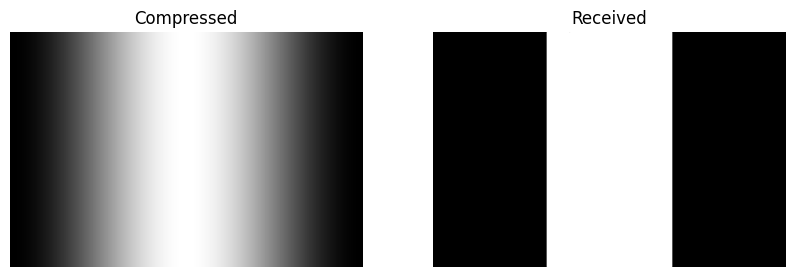

/home/nico/code/digital-comm/venv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/nico/code/digital-comm/venv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Post-signal processing stats: (1334, 2000) -8.17622013379844e-16 1.000000000000001
SSIM: 0.290


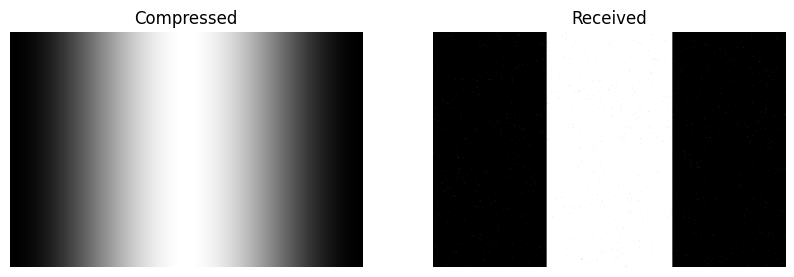

Post-signal processing stats: (1334, 2000) 0 1
SSIM: 0.297


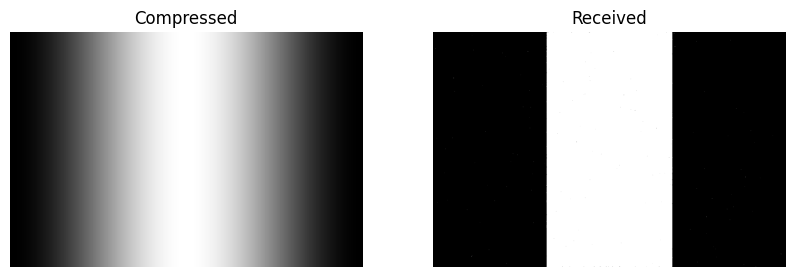

Post-signal processing stats: (1334, 2000) -7.6311387915452105e-16 1.0000000000000009
SSIM: 0.167


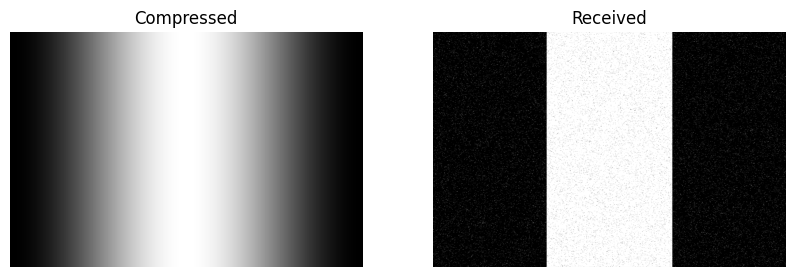

In [15]:
# Read the input image and normalize pixel values to the range [0, 1]
image = plt.imread('./images/kirkland.jpg').astype(float)[:, :, 0] / 255

# Define the list of compression techniques to evaluate
compressions = [dct_compress]

# Define the list of error correction techniques to evaluate
error_corrections = [hamming_error_correction]

# Define the list of signal processing methods to evaluate
signal_methods = [median_filter, wiener_filter]

# Define the list of error rates to introduce during evaluation
error_rates = [0.01, 0.05]

# Call the function to evaluate the techniques on the input image
evaluate_techniques([image], compressions, error_corrections, signal_methods, error_rates)
